In [80]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [306]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

# Tree Height

In [81]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/Forest_height_2019_NAM.tif'
treefull = rxa.open_rasterio(treefp)

In [82]:
for loc, ds in cor_vv.items():
    if 'tree-height' not in cor_vv[loc].data_vars:
        treeclip = treefull.rio.clip_box(*ds.rio.bounds())
        cor_vv[loc]['tree-height'] = treeclip.rio.reproject_match(cor_vv[loc])[0]

In [83]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['tree-height']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_np(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
cors = cors[trees != 0]
trees = trees[(trees != 0)]

In [85]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: -0.0022128898564640186. intercept: 0.5506681180466394. r_value -0.09204349607925778. p value: 0.0


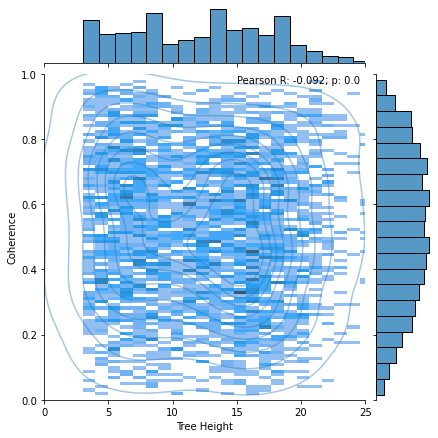

In [86]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 100, ylim = (0,1), xlim = (0,25))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
xs = np.linspace(1, 20, 200)
ys = slope * xs + intercept
# sns.lineplot(x = np.rad2deg(xs),y = ys, zorder = 2, color = 'C1', ax = g.ax_joint)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [15,0.97])
g.ax_joint.set_xlabel('Tree Height')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-tree-height-coh.png'))

# Tree Percentage

In [293]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/nlcd/nlcd_2016_treecanopy_2019_08_31.img'
treefull = rxa.open_rasterio(treefp)

In [294]:
transformer = Transformer.from_crs("epsg:4326", "epsg:5070")
for loc, ds in cor_vv.items():
    if 'tree-perc' not in cor_vv[loc].data_vars:
        left, bottom = transformer.transform(*ds.rio.bounds()[:2][::-1])
        right, top = transformer.transform(*ds.rio.bounds()[2:][::-1])
        treeclip = treefull.rio.clip_box(left, bottom, right, top)
        cor_vv[loc]['tree-perc'] = treeclip.rio.reproject_match(cor_vv[loc])[0]

In [301]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['tree-perc']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_np(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
cors = cors[trees < 101]
trees = trees[(trees < 101)]

In [302]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: -0.0012208193446801752. intercept: 0.5689286699639985. r_value -0.11904959610507074. p value: 0.0


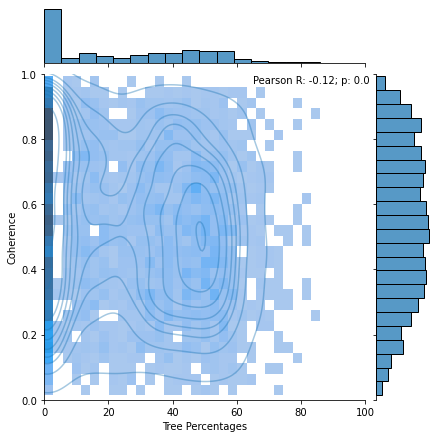

In [303]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 30, ylim = (0,1), xlim = (0,100))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [65,0.97])
g.ax_joint.set_xlabel('Tree Percentages')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-tree-perc-coh.png'))

# Biomass

In [292]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/biomass/conus_forest_biomass_mg_per_ha.img'
treefull = rxa.open_rasterio(treefp)

In [281]:
transformer = Transformer.from_crs("epsg:4326", "epsg:5069")
for loc, ds in cor_vv.items():
    if 'biomass' not in cor_vv[loc].data_vars:
        left, bottom = transformer.transform(*ds.rio.bounds()[:2][::-1])
        right, top = transformer.transform(*ds.rio.bounds()[2:][::-1])
        treeclip = treefull.rio.clip_box(left, bottom, right, top)
        cor_vv[loc]['biomass'] = treeclip.rio.reproject_match(cor_vv[loc])[0]

In [282]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['biomass']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_nps(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
cors = cors[trees < 10000]
trees = trees[(trees < 10000)]
cors = cors[trees > 0]
trees = trees[(trees > 0)]

In [283]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: 0.0002802252467153634. intercept: 0.5170532757260231. r_value 0.08538476705876544. p value: 0.0


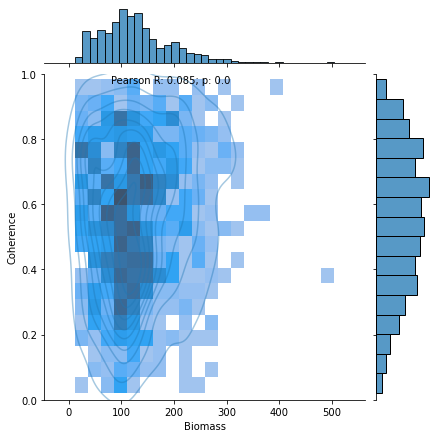

In [284]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 20, ylim = (0,1))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [81,0.97])
g.ax_joint.set_xlabel('Biomass')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-biomass-coh.png'))

# Inc control

In [288]:
trees = []
cors = []
incs = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        direction = band.split('_')[1][:3]
        inc_name = f'{direction}-inc'
        inc = ds[inc_name]
        ts = ds['biomass']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean, incclean = clean_nps([ts.values.ravel(), cor['cor_vv'].values.ravel(), inc.values.ravel()])
        trees.append(insclean)
        cors.append(csclean)
        incs.append(incclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
cors = cors[trees < 1000]
incs = incs[trees < 1000]
trees = trees[(trees < 1000)]
cors = cors[trees > 0]
incs = incs[trees > 0]
trees = trees[(trees > 0)]
incs = np.rad2deg(incs)

In [289]:
slope, intercept,r,p, _, _ = r2_value(trees[(incs < 65) & (incs > 40)], cors[(incs < 65) & (incs > 40)])

slope: 0.00036430363251156804. intercept: 0.518253401063655. r_value 0.10817093911183454. p value: 0.0


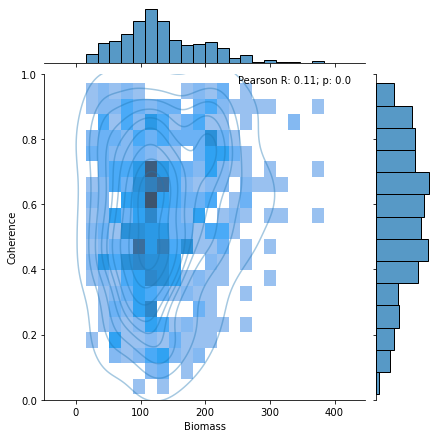

In [291]:
med_inc = (incs < 65) & (incs > 40)

plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[med_inc][::50000], y = cors[med_inc][::50000], kind = 'hist', bins = 20, ylim = (0,1))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [250,0.97])
g.ax_joint.set_xlabel('Biomass')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-biomass-inc-coh.png'))

# inc control percentage

In [313]:
trees = []
cors = []
incs = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        direction = band.split('_')[1][:3]
        inc_name = f'{direction}-inc'
        inc = ds[inc_name]
        ts = ds['tree-perc']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean, incclean = clean_nps([ts.values.ravel().astype(float), cor['cor_vv'].values.ravel(), inc.values.ravel()])
        trees.append(insclean)
        cors.append(csclean)
        incs.append(incclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
cors = cors[trees < 101]
incs = incs[trees < 101]
trees = trees[(trees < 101)]
incs = np.rad2deg(incs)

In [322]:
med_inc = (incs < 60) & (incs > 40)
slope, intercept,r,p, _, _ = r2_value(trees[med_inc], cors[med_inc])

slope: -0.0019906411086118305. intercept: 0.619409230570193. r_value -0.20089563117082698. p value: 0.0


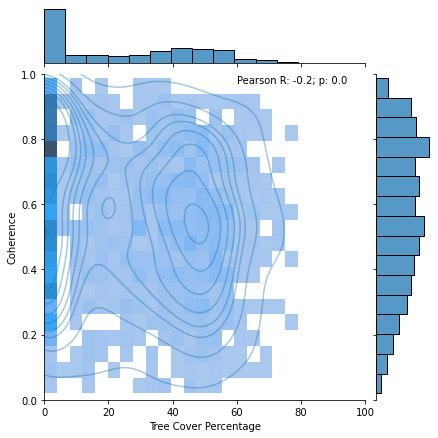

In [326]:
med_inc = (incs < 60) & (incs > 40)

plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[med_inc][::50000], y = cors[med_inc][::50000], kind = 'hist', bins = 20, ylim = (0,1), xlim = (0,100))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [60,0.97])
g.ax_joint.set_xlabel('Tree Cover Percentage')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-perc-inc-coh.png'))